### Loading Data and libraries

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

# paths
mrl_root = "Data/MRL/data"


# Show where we are starting
print("Before:", os.getcwd())

print("Before:", os.getcwd())

if os.path.basename(os.getcwd()) != "Deep-Learning-Drowsiness-Prediction":
    if os.path.exists("Deep-Learning-Drowsiness-Prediction"):
        os.chdir("Deep-Learning-Drowsiness-Prediction")

print("Now in:", os.getcwd())
print("Listing:", os.listdir())

print("Now in:", os.getcwd())
print("Listing:", os.listdir())  # you should see Data, README.md, etc.

IMG_SIZE = (64, 64)
BATCH_SIZE = 64

train_dir = os.path.join(mrl_root, "train")
val_dir   = os.path.join(mrl_root, "val")
test_dir  = os.path.join(mrl_root, "test")

2025-12-03 00:07:39.911834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764720459.932957  140345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764720459.939505  140345 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764720459.956633  140345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764720459.956652  140345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764720459.956655  140345 computation_placer.cc:177] computation placer alr

TF: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Before: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code
Now in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dldrowsinessdetection/code/Deep-Learning-Drowsiness-Prediction
Listing: ['.git', '.gitignore', 'Data', 'Data Gathering', 'Modeling', 'Models', 'README.md']


### Preprocessing and augmentation

In [7]:
base_train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

base_val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
)

base_test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("Class names:", base_train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
])

def preprocess(image, label, training=False):
    image = tf.cast(image, tf.float32) / 255.0
    if training:
        image = data_augmentation(image, training=True)
    return image, label

def prepare_dataset(ds, training=False):
    ds = ds.map(
        lambda x, y: preprocess(x, y, training=training),
        num_parallel_calls=AUTOTUNE,
    )
    if training:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare_dataset(base_train_ds, training=True)
val_ds   = prepare_dataset(base_val_ds,   training=False)
test_ds  = prepare_dataset(base_test_ds,  training=False)

Found 50937 files belonging to 2 classes.


I0000 00:00:1764720466.966867  140345 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 518 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Found 16980 files belonging to 2 classes.
Found 16981 files belonging to 2 classes.
Class names: ['awake', 'sleepy']


### Model 1- Baseline CNN (per-frame awake vs sleepy)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def build_baseline_cnn(input_shape=(64, 64, 1)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn_mrl")
    return model

model_cnn = build_baseline_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model_cnn.summary()

Model: "baseline_cnn_mrl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,505 (4.35 MB)

 Trainable params: 1,141,505 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/15


2025-12-03 00:08:03.618028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 41 of 1000
2025-12-03 00:08:13.625163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 82 of 1000
2025-12-03 00:08:33.498528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 164 of 1000
2025-12-03 00:08:53.454471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 250 of 1000
2025-12-03 00:09:03.620677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 294 of 1000
2025-12-03 00:09:23.472360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a wh

796/796 - 281s - 353ms/step - accuracy: 0.9092 - loss: 0.2338 - val_accuracy: 0.9597 - val_loss: 0.1031
Epoch 2/15
796/796 - 4s - 5ms/step - accuracy: 0.9608 - loss: 0.1131 - val_accuracy: 0.9701 - val_loss: 0.0787
Epoch 3/15
796/796 - 4s - 5ms/step - accuracy: 0.9698 - loss: 0.0881 - val_accuracy: 0.9757 - val_loss: 0.0658
Epoch 4/15
796/796 - 4s - 5ms/step - accuracy: 0.9743 - loss: 0.0739 - val_accuracy: 0.9804 - val_loss: 0.0561
Epoch 5/15
796/796 - 4s - 5ms/step - accuracy: 0.9780 - loss: 0.0643 - val_accuracy: 0.9798 - val_loss: 0.0576
Epoch 6/15
796/796 - 4s - 5ms/step - accuracy: 0.9807 - loss: 0.0573 - val_accuracy: 0.9820 - val_loss: 0.0511
Epoch 7/15
796/796 - 4s - 5ms/step - accuracy: 0.9815 - loss: 0.0520 - val_accuracy: 0.9826 - val_loss: 0.0516
Epoch 8/15
796/796 - 4s - 5ms/step - accuracy: 0.9832 - loss: 0.0480 - val_accuracy: 0.9830 - val_loss: 0.0515
Epoch 9/15
796/796 - 4s - 5ms/step - accuracy: 0.9846 - loss: 0.0433 - val_accuracy: 0.9853 - val_loss: 0.0478
Epoch 10

In [10]:
test_loss, test_acc = model_cnn.evaluate(test_ds, verbose=2)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

2025-12-03 00:15:04.831477: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.10 = (f32[21,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,32,32,32]{3,2,1,0} %bitcast.411, f32[64,32,3,3]{3,2,1,0} %bitcast.418, f32[64]{0} %bitcast.420), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="baseline_cnn_mrl_1/conv2d_1_2/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-03 00:15:04.848866: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

266/266 - 101s - 380ms/step - accuracy: 0.9859 - loss: 0.0451
Test accuracy: 0.9858665466308594
Test loss: 0.045149412006139755


### Save model

In [11]:
model_cnn.save("Models/baseline_cnn_mrl.keras")

### Graphs

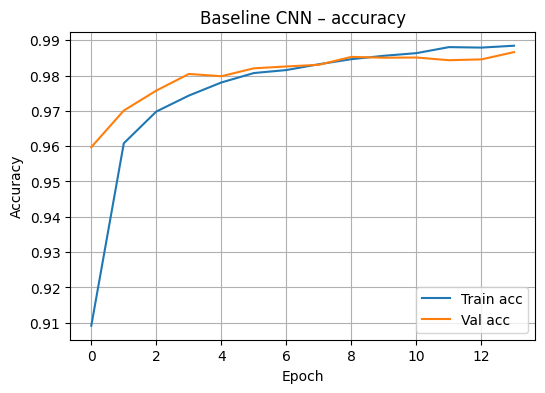

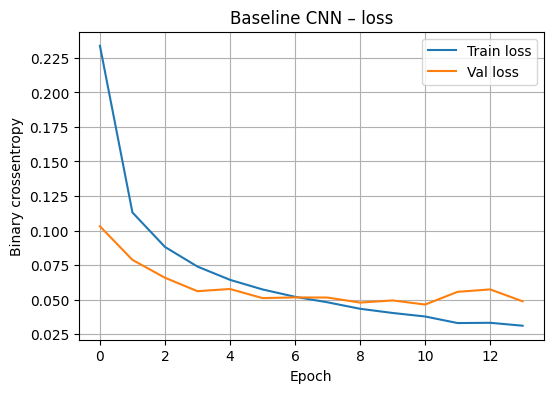

In [12]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    hist = history.history

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="Train acc")
    plt.plot(hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Baseline CNN – accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.title("Baseline CNN – loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curves(history)

### Evaluation on test set

In [13]:
import sys
!{sys.executable} -m pip install -U scikit-learn

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1) Overall test performance
test_loss, test_acc = model_cnn.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

# 2) Collect predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_cnn.predict(images, verbose=0)
    y_true.extend(labels.numpy().ravel())
    y_pred.extend((preds.ravel() > 0.5).astype(int))  # threshold 0.5

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

target_names = ["awake", "sleepy"]
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

  1/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9688 - loss: 0.1248

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9832 - loss: 0.0541
Test accuracy: 0.9858665466308594
Test loss: 0.045149412006139755


2025-12-03 00:15:08.343294: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.10 = (f32[32,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,32]{3,2,1,0} %bitcast.244, f32[64,32,3,3]{3,2,1,0} %bitcast.251, f32[64]{0} %bitcast.253), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="baseline_cnn_mrl_1/conv2d_1_2/convolution" source_file="/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-12-03 00:15:08.373991: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

y_true shape: (16981,)
y_pred shape: (16981,)
              precision    recall  f1-score   support

       awake       0.99      0.98      0.99      8591
      sleepy       0.98      0.99      0.99      8390

    accuracy                           0.99     16981
   macro avg       0.99      0.99      0.99     16981
weighted avg       0.99      0.99      0.99     16981

Confusion matrix:
 [[8446  145]
 [  95 8295]]


2025-12-03 00:15:25.527874: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
